In [22]:
import anthropic

# load dotenv for the api_key
import os
from dotenv import load_dotenv
load_dotenv()

client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key = os.getenv("ANTHROPIC_API_KEY"),
)


import json

def save_data(message,  data, name_of_file='augmented_dark_pattern_claude.json'):
    # Cargar los datos existentes
    try:
        with open(name_of_file, 'r') as f:
            resultados = json.load(f)
    except FileNotFoundError:
        print("File not found")
        print("Creating a new file")
        resultados = []

    # Agregar los nuevos datos
    nuevos_datos = json.loads(message.json())
    content_nuevos_datos = json.loads(nuevos_datos["content"][0]["text"])
    content_nuevos_datos["Original Data"] = {"Text": data['text'], "Original Label": data['label']}
    nuevos_datos["content"][0]["text"] = content_nuevos_datos
    resultados.append(nuevos_datos)

    # Guardar los datos actualizados
    with open(name_of_file, 'w') as f:
        json.dump(resultados, f)

    print(f"Data saved in {name_of_file}")
    print("The length of the dataset after appending the new message is: ", len(resultados))

### Load original data

In [42]:
import pandas as pd
from tqdm import tqdm
import time

df_original = pd.read_json("/home/AI_projects/PAN_24/PAN_24_Opposing/DATA/train/dataset_en_train.json")

# get a sample of the dataset
sample = df_original.sample(1, random_state=12)
sample = df_original.loc[50:100]


# renme "category" to "label"
sample.rename(columns={"category": "label"}, inplace=True)
sample.value_counts("label")
        

/tmp/ipykernel_2721556/241192791.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.rename(columns={"category": "label"}, inplace=True)


label
CRITICAL      33
CONSPIRACY    18
dtype: int64

In [12]:
df_original.shape

(4000, 5)

In [44]:
# prepare the data for the API
for i, data in tqdm(enumerate(sample.to_dict(orient="records")), desc="Sending data to the API"):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"Original Data: \"{data['text']}\"\nOringinal Label: {data['label']}",
                }
            ],
        }
    ]
    message = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=1000,
        temperature=0,
        system = """ 
        Your role is to analyze text inputs to identify whether they represent critical commentary or conspiracy theories, each with distinct characteristics:

Critical Commentary:

Definition: Analyzes or evaluates topics, events, or works (like literature, politics, or social issues), expressing opinions based on informed judgment.
Characteristics:
Informed Opinion: Grounded in knowledge, research, and expertise, beyond personal feelings.
Constructive: Aims to offer insightful perspectives or suggest improvements.
Open to Debate: Invites discussion and welcomes counterarguments.
Applicability: Applies even when the topic might be susceptible to conspiratorial interpretations.
Conspiracy Theories:

Definition: Beliefs attributing significant events or phenomena to secret, malevolent groups or organizations with hidden agendas.
Characteristics:
Lack of Evidence: Often speculative with minimal empirical support.
Suspicion and Paranoia: Thrives on distrust of official narratives and institutions.
Simplistic Explanations: Oversimplifies complexities by attributing them to the actions of a few.
Resistance to Evidence: Dismisses contrary evidence as part of the cover-up.
Task Requirements:

Classify the narrative of the text as either 'CONSPIRACY' or 'CRITICAL'. Use the characteristics outlined to identify the narrative style accurately.
Determine the main topics of the text in 2-3 words that capture the essence succinctly.
Assign a Confidence Score from 0 to 1, indicating the certainty of your classification and alignment with the narrative characteristics.
Provide a brief reason for your classification, summarizing why the text was categorized based on the given characteristics.

{
  "Prediction": "CRITICAL" or "CONSPIRACY",
  "Confidence": [Confidence Score],
  "Topic": ["topic1", "topic2", "topic3"],
  "Reason": "A concise explanation based on the characteristics of the predicted category."
}        
        """,
        
        
#         """ 
#         Your role is to analyze text inputs to identify the underlying narrative style: critical thinking or conspiracy theories. Critical thinking involves questioning major decisions or events without attributing malevolent intent, whereas conspiracy theories often suggest covert, sinister actions by powerful entities. You are required to:

# Classify the narrative of the text as either 'CONSPIRACY' or 'CRITICAL'. Consider typical language used in conspiracy theories, such as 'secret', 'hide', or 'manipulate', versus language associated with critical thinking, like 'analyze', 'question', or 'consider'.

# Determine the main topics of the text in 2-3 words that encapsulate the subject matter succinctly.

# Assign a Confidence Score on a scale from 0 to 1, representing the certainty of your classification and how definitively the text aligns with the identified narrative.

# Provide a brief reason for your classification, summarizing why the text was categorized as either 'CRITICAL' or 'CONSPIRACY'.

# The results should be json formatted as follows:
# {
#   "Prediction": "CRITICAL" or "CONSPIRACY",
#   "Confidence": [Confidence Score],
#   "Topic": ["topic1", "topic2", "topic3"],
#   "Reason": "A concise explanation of the rationale behind the prediction."
# }
#         """,


#         system="""
# Your role is to analyze text input to differentiate between oppositional narratives: one being critical thinking and the other conspiracy theories. Critical thinking questions major decisions or events without necessarily imputing sinister motives, while conspiracy theories typically suggest covert and malevolent actions by powerful entities controlling or manipulating these events.

# For each text input, you are required to:

# Classify the narrative as either 'CONSPIRACY' or 'CRITICAL'. Each classification should consider the presence of typical conspiracy language like 'secret,' 'hide,' or 'manipulate' versus critical thinking which might include terms like 'analyze,' 'question,' or 'consider'.

# Generate three variations of the given text:

# Two variations should enhance the input's narrative style while maintaining the original label, focusing on subtler or more explicit language depending on the category.
# One variation should alter the text significantly to convert it into the opposite category. This should be achieved by changing the underlying assumptions or by introducing or removing claims of malign intent.
# Assign a Confidence Score for each variation on a scale from 0 to 1, indicating how effectively the variation aligns with its intended category and the quality of the alteration. Be critic and self-aware of the certainty of confidence of the quality, considering how similar in semantics and the topic and entialment alignment with the original label.

# The results should be formatted as follows:

# {
#   "Augmented Variations": [
#     {
#       "Text": "[Variation 1]",
#       "Label": "[CONSPIRACY or CRITICAL]",
#       "Confidence": "[Confidence Score]",
#     },
#     {
#       "Text": "[Variation 2]",
#       "Label": "[CONSPIRACY or CRITICAL]",
#       "Confidence": "[Confidence Score]"
#     },
#     {
#       "Text": "[Variation 3]",
#       "Label": "[OPPOSITE LABEL]",
#       "Confidence": "[Confidence Score]"
#     }
#   ]
# }
# """,
        messages=messages,
    )


    # save the data
    name_of_file = "response_v3_PAN_EN_claude.json"
    try:
      save_data(message, data, name_of_file )
    except Exception as e:
      print("Error saving the data: ", e)
    # Esperar 30 segundos con la barra de progreso de tqdm

    if i % 10 == 0:
        preds = []
        y_true = []
        for instance in augmented_data:
            preds.append( instance["content"][0]["text"]["Prediction"] )
            y_true.append( instance["content"][0]["text"]["Original Data"]["Original Label"] )
        preds = np.array(preds)
        y_true = np.array(y_true)

        # Calcular MCC
        mcc = matthews_corrcoef(y_true, preds)
        print("Step: ", i)
        print(f"MCC: {mcc}")

        # Calcular F1
        f1 = f1_score(y_true, preds, average='weighted')
        print(f"F1 Score: {f1}")

        # Calcular precisión
        accuracy = accuracy_score(y_true, preds)
        print(f"Accuracy: {accuracy}")

    for i in tqdm(range(30), desc="Waiting for 30 seconds"):
        time.sleep(1)

Sending data to the API: 0it [00:00, ?it/s]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  48
Step:  0
MCC: 0.2362820946305948
F1 Score: 0.36580246086509904
Accuracy: 0.45652173913043476


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 1it [00:40, 40.71s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  49


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 2it [01:23, 42.21s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  50


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 3it [02:04, 41.42s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  51


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 4it [02:42, 40.25s/it]

Error saving the data:  Expecting value: line 1 column 1 (char 0)


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 5it [03:29, 42.64s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  52


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 6it [04:09, 41.72s/it]

Error saving the data:  Expecting value: line 1 column 1 (char 0)


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 7it [04:52, 42.01s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  53


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 8it [05:29, 40.42s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  54


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 9it [06:06, 39.53s/it]

Error saving the data:  Expecting value: line 1 column 1 (char 0)


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 10it [06:57, 42.84s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  55
Step:  10
MCC: 0.2362820946305948
F1 Score: 0.36580246086509904
Accuracy: 0.45652173913043476


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 11it [07:35, 41.34s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  56


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 12it [08:13, 40.54s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  57


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 13it [08:49, 39.19s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  58


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 14it [09:27, 38.59s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  59


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 15it [10:04, 38.16s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  60


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 16it [10:40, 37.63s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  61


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 17it [11:19, 38.10s/it]

Error saving the data:  Expecting value: line 1 column 1 (char 0)


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 18it [12:03, 39.91s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  62


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 19it [12:45, 40.50s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  63


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 20it [13:26, 40.59s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  64
Step:  20
MCC: 0.2362820946305948
F1 Score: 0.36580246086509904
Accuracy: 0.45652173913043476


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 21it [14:04, 39.71s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  65


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 22it [14:42, 39.19s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  66


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 23it [15:21, 39.15s/it]

Error saving the data:  Expecting value: line 1 column 1 (char 0)


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 24it [16:07, 41.35s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  67


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 25it [16:46, 40.56s/it]

Error saving the data:  Expecting value: line 1 column 1 (char 0)


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 26it [17:35, 43.20s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  68


Waiting for 30 seconds: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]
Sending data to the API: 27it [18:17, 42.74s/it]

Data saved in response_v3_PAN_EN_claude.json
The length of the dataset after appending the new message is:  69


Waiting for 30 seconds:  40%|████      | 12/30 [00:12<00:18,  1.05s/it]
Sending data to the API: 27it [18:37, 41.38s/it]


KeyboardInterrupt: 

#### API Call to Augmente Data

In [53]:

message = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1000,
    temperature=0,
    system="Your role is to act as a data augmentation tool focused on generating data variations for dark patterns. Dark patterns are deceptive designs in user interfaces intended to make users behave in ways they do not intend.\n\nGiven the input data, generate three variations for data augmentation. Two variations should maintain the original label, while one should be altered significantly enough to belong to the opposite category. The categories for labeling are: 0 for 'Not Dark Pattern', and 1 for 'Dark Pattern'. Each variation should strive to maintain the core characteristics of the original input but alter aspects such as wording, structure, etc., to enhance model training diversity.\n\nAdditionally, for each augmented data, provide a 'Confidence' score between 0 and 1 that represents how well the new variations adhere to the assigned label and the quality of the variation.\n\nPlease return the output in the following JSON format:\n\n{\n  \"Original Data\": \"[Original Text]\",\n  \"Original Label\": \"[Appropriate Category]\",\n  \"Augmented Variations\": [\n    {\n      \"Augmented Data\": \"[Variation 1]\",\n      \"Label\": \"[Appropriate Category]\",\n      \"Confidence\": \"[Confidence Score]\"\n    },\n    {\n      \"Augmented Data\": \"[Variation 2]\",\n      \"Label\": \"[Appropriate Category]\",\n      \"Confidence\": \"[Confidence Score]\"\n    },\n    {\n      \"Augmented Data\": \"[Variation 3]\",\n      \"Label\": \"[Appropriate Category]\",\n      \"Confidence\": \"[Confidence Score]\"\n    }\n  ]\n}\n",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Original Data: \"To start your return, simply click on the following button and add your return details. Once the form is filled, you will receive an email with shipping instructions for how to ship the item(s) to our warehouse.\"\nOringinal Label: 0"
                }
            ]
        }
    ]
)
print(message.content)

# save_data(message)
name_of_file='augmented_dark_pattern_claude.json'
save_data(message, name_of_file)

[ContentBlock(text='{\n  "Original Data": "To start your return, simply click on the following button and add your return details. Once the form is filled, you will receive an email with shipping instructions for how to ship the item(s) to our warehouse.",\n  "Original Label": 0,\n  "Augmented Variations": [\n    {\n      "Augmented Data": "Click the button below to initiate your return. After completing the form, you\'ll get an email with instructions on how to send the item(s) to our warehouse.",\n      "Label": 0,\n      "Confidence": 0.9\n    },\n    {\n      "Augmented Data": "To begin the return process, press the button and provide the necessary return details. An email with shipping guidelines will be sent once the form is submitted.",\n      "Label": 0,\n      "Confidence": 0.8\n    },\n    {\n      "Augmented Data": "Attention shoppers! If you\'re not satisfied with your purchase, simply click the button to start the return process. But be warned, the return window is only op

### Load the JSON augmented file

In [45]:
# load the json file and print the content
with open(name_of_file, 'r') as f:
    augmented_data = json.load(f)

In [50]:
import numpy as np
preds = []
y_true = []
for instance in augmented_data:
    preds.append( instance["content"][0]["text"]["Prediction"] )
    y_true.append( instance["content"][0]["text"]["Original Data"]["Original Label"] )
    print("PREDICT -> ", instance["content"][0]["text"]["Prediction"])
    print("REAL -> ", instance["content"][0]["text"]["Original Data"]["Original Label"])
    print()

from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score

# Convertir las listas a arrays de numpy para el cálculo de las métricas
preds = np.array(preds)
y_true = np.array(y_true)

# Calcular MCC
mcc = matthews_corrcoef(y_true, preds)
print(f"MCC: {mcc}")

# Calcular F1
f1 = f1_score(y_true, preds, average='weighted')
print(f"F1 Score: {f1}")

# Calcular precisión
accuracy = accuracy_score(y_true, preds)
print(f"Accuracy: {accuracy}")

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, preds))

PREDICT ->  CONSPIRACY
REAL ->  CONSPIRACY

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CONSPIRACY

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CONSPIRACY

PREDICT ->  CONSPIRACY
REAL ->  CONSPIRACY

PREDICT ->  CONSPIRACY
REAL ->  CONSPIRACY

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CONSPIRACY

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CONSPIRACY

PREDICT ->  CONSPIRACY
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CONSPIRACY

PREDICT ->  CRITICAL
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CONSPIRACY

PREDICT ->  CRITICAL
REAL ->  CRITICAL

PREDICT ->  CONSPIRACY
REAL ->  CONSPIRACY

PREDICT ->  CONSPI

In [49]:
from collections import Counter
print(Counter(y_true))
Counter(preds)

Counter({'CRITICAL': 39, 'CONSPIRACY': 30})


Counter({'CONSPIRACY': 65, 'CRITICAL': 4})

#### Get confidence of results

In [78]:
import numpy as np
results = {}
for i, msg in enumerate(augmented_data):
    model_used = msg["model"]
    content = msg['content'][0]
    conf_values = []
    # for aug_var in json.loads(content["text"] )["Augmented Variations"]: 
    for aug_var in content["text"]["Augmented Variations"]: 

        conf = aug_var["Confidence"]
        conf_values.append(conf)
    conf_values = np.array(conf_values).astype(float)
    
    print(f"confidence for message {i} using {model_used} -> {np.mean(conf_values)} ")
    print(f"{conf_values}\n")
    
    results[i] = {"model_used": model_used, "confidence": conf_values }

confidence for message 0 using claude-3-haiku-20240307 -> 0.8000000000000002 
[0.8 0.9 0.7]

confidence for message 1 using claude-3-haiku-20240307 -> 0.7666666666666666 
[0.8 0.7 0.8]

confidence for message 2 using claude-3-haiku-20240307 -> 0.8333333333333334 
[0.8 0.9 0.8]

confidence for message 3 using claude-3-haiku-20240307 -> 0.8333333333333334 
[0.8 0.9 0.8]

confidence for message 4 using claude-3-haiku-20240307 -> 0.8000000000000002 
[0.8 0.9 0.7]

confidence for message 5 using claude-3-haiku-20240307 -> 0.7666666666666666 
[0.8 0.7 0.8]

confidence for message 6 using claude-3-haiku-20240307 -> 0.8333333333333334 
[0.8 0.9 0.8]

confidence for message 7 using claude-3-haiku-20240307 -> 0.8666666666666667 
[0.8 0.9 0.9]

confidence for message 8 using claude-3-haiku-20240307 -> 0.8666666666666667 
[0.8 0.9 0.9]

confidence for message 9 using claude-3-haiku-20240307 -> 0.7666666666666666 
[0.8 0.7 0.8]

confidence for message 10 using claude-3-haiku-20240307 -> 0.800000000

confidence for model claude-3-opus-20240229 -> 0.9066666666666667 
confidence for model claude-3-haiku-20240307 -> 0.796969696969697 


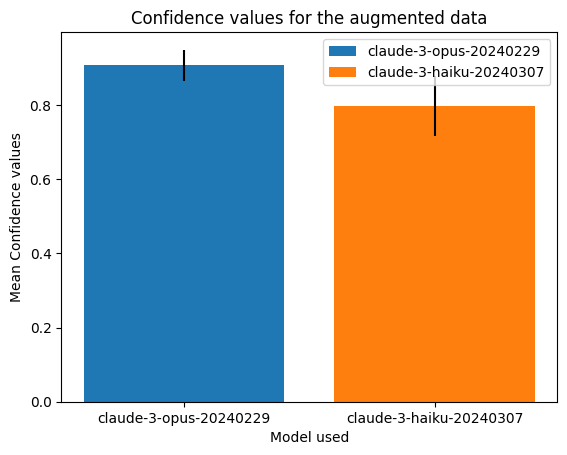

In [136]:
# loop thorugh results get the mean of the confidence values, group by model_used and print the results
from collections import defaultdict
results_grouped = defaultdict(list)
for key, value in results.items():
    results_grouped[value["model_used"]].append(value["confidence"])

for model, conf_values in results_grouped.items():
    conf_values = np.array(conf_values).flatten()
    print(f"confidence for model {model} -> {np.mean(conf_values)} ")

# plot the results for each group of models
# barplot with Xaxis the model used and Y the mean of the confidence values with error bars
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for model, conf_values in results_grouped.items():
    conf_values = np.array(conf_values).flatten()
    ax.bar(model, np.mean(conf_values), yerr=np.std(conf_values), label=model)

# title
plt.title('Confidence values for the augmented data')
# x-axis label
plt.xlabel('Model used')
# y-axis label
plt.ylabel('Mean Confidence values')
plt.legend()
plt.show()




